In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle

import tensorflow as tf
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator, image

from keras.applications.xception import Xception, decode_predictions
from keras.applications.xception import preprocess_input as preprocess_input_xce

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_incV3

from keras.applications.efficientnet import EfficientNetB7
from keras.applications.efficientnet import preprocess_input as preprocess_input_eff

from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input as preprocess_input_res

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16

### Creating folders and organizing images

In [3]:
if not os.path.exists('./train'):
    os.mkdir('./train')
if not os.path.exists('./train/cup'):
    os.mkdir('./train/cup')     
if not os.path.exists('./train/fork'):
    os.mkdir('./train/fork')     
if not os.path.exists('./train/glass'):
    os.mkdir('./train/glass')     
if not os.path.exists('./train/knife'):
    os.mkdir('./train/knife')     
if not os.path.exists('./train/plate'):
    os.mkdir('./train/plate')     
if not os.path.exists('./train/spoon'):
    os.mkdir('./train/spoon')     
    
if not os.path.exists('./test'):
    os.mkdir('./test')
    
trainList = pd.read_csv('train.csv')

In [4]:
for img in os.listdir('./images'):
    
    if (not os.path.exists(f'./train/{img}')) and (not(os.path.exists(f'./test/{img}'))):
        imgName = int(img.split('.')[0])
        
        if imgName in trainList.Id.values:
            
            imgLabel = trainList[trainList.Id == imgName].label.values
            
            if imgLabel == 'cup':
                shutil.copy(f'./images/{img}', f'./train/cup/{img}')
            elif imgLabel == 'fork':
                shutil.copy(f'./images/{img}', f'./train/fork/{img}')
            elif imgLabel == 'glass':
                shutil.copy(f'./images/{img}', f'./train/glass/{img}')
            elif imgLabel == 'knife':
                shutil.copy(f'./images/{img}', f'./train/knife/{img}')
            elif imgLabel == 'plate':
                shutil.copy(f'./images/{img}', f'./train/plate/{img}')
            elif imgLabel == 'spoon':
                shutil.copy(f'./images/{img}', f'./train/spoon/{img}')

        else:            
            
            shutil.copy(f'./images/{img}', f'./test/{img}')
            
totalTrainImgs = len(os.listdir("./train/cup")) + len(os.listdir("./train/fork")) + \
                len(os.listdir("./train/glass")) + len(os.listdir("./train/knife")) + \
                len(os.listdir("./train/plate")) + len(os.listdir("./train/spoon"))

totalTestImgs = len(os.listdir("./test"))

print(f'There is a total of {totalTrainImgs} images in the training set')
print(f'There is a total of {totalTestImgs} images in the test set')            

There is a total of 5559 images in the training set
There is a total of 3808 images in the test set


### Image Generators

In [5]:
pixels = 500

def ProcInputs(modelName):
    
    preprocessInputs = {'Xception': preprocess_input_xce,
                    'InceptionV3': preprocess_input_incV3,
                    'efficientnetB7': preprocess_input_eff,
                    'ResNet50V2': preprocess_input_res,
                    'VGG16' : preprocess_input_vgg16
                   }
    return preprocessInputs[modelName]


def DataGenerators (modelName, split=0.2):
   
    preprocess_input = ProcInputs(modelName)
    
    dataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        validation_split=split,
                                        #rotation_range=30,
                                        #shear_range=0.2,
                                        #zoom_range=0.3,
                                        #vertical_flip=True
                                        #brightness_range=(20,40),
                                        #featurewise_std_normalization=True
                                      )    

    trainGenerator = dataGenerator.flow_from_directory(directory='./train',
                                                         batch_size=32,
                                                         target_size=(pixels, pixels), 
                                                         subset="training",
                                                         shuffle=True,
                                                         class_mode='categorical')

    valGenerator = dataGenerator.flow_from_directory(directory='./train',
                                                       batch_size=16,
                                                       target_size=(pixels, pixels),
                                                       subset="validation",
                                                       shuffle=True,
                                                       class_mode='categorical')
    
    return trainGenerator, valGenerator

### Getting model configurations

In [6]:
def GetModel(modelName):
    
    basemodel_Xce = tf.keras.applications.Xception(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(pixels, pixels, 3))

    basemodel_Inc = tf.keras.applications.InceptionV3(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(pixels, pixels, 3))
    
    basemodel_EffB7 = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                       include_top=False,
                                                       input_shape=(pixels, pixels, 3)) 

    basemodel_Res50V2 = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet',
                                                                 include_top=False,
                                                                 input_shape=(pixels, pixels, 3)
                                                                  ) 

    basemodel_VGG16 = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                                          include_top=False,
                                                          input_shape=(pixels, pixels, 3),
                                                       ) 
    
   
    basemodels = {'Xception': basemodel_Xce,
                  'InceptionV3': basemodel_Inc,
                  'efficientnetB7': basemodel_EffB7,
                  'ResNet50V2': basemodel_Res50V2,
                  'VGG16' : basemodel_VGG16
                 }
    
    return basemodels[modelName]

### Building the model

In [7]:
def MakeModel(modelName = 'Xception', learning_rate = 0.001, size_inner=128, droprate=0.3):
    
    base_model = GetModel(modelName)
    
    base_model.trainable = False

    inputs = Input(shape=(pixels, pixels, 3))
    base = base_model(inputs, training=False)
    vectors = layers.GlobalAveragePooling2D()(base)
    
    inner = layers.Dense(size_inner, activation='relu')(vectors)
    drop = layers.Dropout(droprate)(inner)
    
    outputs = layers.Dense(6, activation='softmax')(drop)
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=learning_rate)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

### Checkpointing

In [8]:
def GetCheckpoint(modelName):
    checkpoint = keras.callbacks.ModelCheckpoint(modelName + '_{epoch:02d}_{val_accuracy:.3f}.h5',
                                                 save_best_only=True,
                                                 #save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')
    return checkpoint

def GetCheckpointFull(modelName):
    checkpoint = keras.callbacks.ModelCheckpoint(modelName + '_{epoch:02d}_{accuracy:.3f}.h5',
                                                 save_best_only=True,
                                                 #save_weights_only=True,
                                                 monitor='accuracy',
                                                 mode='max')
    return checkpoint


#plateau = tf.keras.callbacks.ReduceLROnPlateau(
#    monitor="val_loss",
#    factor=0.1,
#    patience=10,
#    mode="auto",
#    min_lr=0.0001,
#)

### All the models

In [ ]:
scores = {}
lr = 0.001
size = 128
droprate = 0.3
models = ['Xception', 'InceptionV3', 'efficientnetB7', 'ResNet50V2', 'VGG16']

for modelName in models:
    trainGenerator, valGenerator = DataGenerators (modelName)
    checkpoint = GetCheckpoint(modelName)
    model = MakeModel(modelName=modelName, learning_rate=lr, size_inner=size, droprate=droprate)
    history = model.fit(trainGenerator, validation_data=valGenerator, steps_per_epoch=50, epochs=15, callbacks=[checkpoint])
   

In [27]:
def RunModel(learningRates, modelName, steps_per_epoch=40, epochs=15):
    
    scores = {}
    size = 128
    droprate = 0.3
    #learningRates = [0.0004, 0.0007, 0.001, 0.003]
    #modelName = 'Xception'

    trainGenerator, valGenerator = DataGenerators (modelName)
    print()

    for lr in learningRates:
        print(f'Learning rate: {lr}')
        checkpoint = GetCheckpoint(modelName + '_' + f'lr{lr}')
        model = MakeModel(modelName=modelName, learning_rate=lr)
        history = model.fit(trainGenerator,
                            validation_data=valGenerator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs,
                            callbacks=[checkpoint])
        scores[lr] = history.history
        print('\n')
    
    return model, history, scores


### Plot history

In [10]:
def PlotHistory(scores, lims=[0.9,0.98], xaxis=15):
        
    for lr , hist in scores.items():
        plt.plot(hist['val_accuracy'], label=lr)

    plt.xticks(np.arange(xaxis))
    plt.ylim(lims[0], lims[1])
    plt.legend()

### Finding best Learning rates for models

### Xception

In [28]:
learningRates = [0.0004, 0.0007, 0.001, 0.003]
modelName = 'Xception'
model_X, history_X, scores_X = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/15
40/40 [==============================] - 19s 436ms/step - loss: 0.9515 - accuracy: 0.7703 - val_loss: 0.4114 - val_accuracy: 0.9405
Epoch 2/15
40/40 [==============================] - 17s 424ms/step - loss: 0.3531 - accuracy: 0.9164 - val_loss: 0.2327 - val_accuracy: 0.9549
Epoch 3/15
40/40 [==============================] - 17s 425ms/step - loss: 0.2378 - accuracy: 0.9406 - val_loss: 0.1834 - val_accuracy: 0.9576
Epoch 4/15
40/40 [==============================] - 17s 425ms/step - loss: 0.1875 - accuracy: 0.9438 - val_loss: 0.1589 - val_accuracy: 0.9612
Epoch 5/15
40/40 [==============================] - 17s 425ms/step - loss: 0.1775 - accuracy: 0.9508 - val_loss: 0.1456 - val_accuracy: 0.9621
Epoch 6/15
40/40 [==============================] - 17s 424ms/step - loss: 0.1440 - accuracy: 0.9578 - val_loss: 0.1375 - val_accuracy: 0.9666
Epoch 7/15
40/40 [=================

Epoch 12/15
40/40 [==============================] - 17s 428ms/step - loss: 0.0954 - accuracy: 0.9703 - val_loss: 0.1415 - val_accuracy: 0.9576
Epoch 13/15
40/40 [==============================] - 17s 428ms/step - loss: 0.0858 - accuracy: 0.9758 - val_loss: 0.0934 - val_accuracy: 0.9702
Epoch 14/15
40/40 [==============================] - 17s 428ms/step - loss: 0.0983 - accuracy: 0.9672 - val_loss: 0.0992 - val_accuracy: 0.9739
Epoch 15/15
40/40 [==============================] - 17s 427ms/step - loss: 0.0880 - accuracy: 0.9712 - val_loss: 0.1093 - val_accuracy: 0.9666




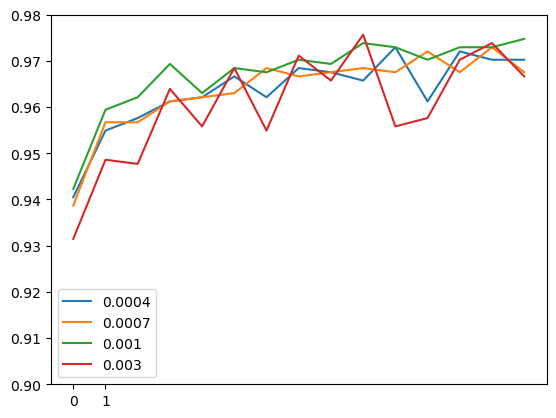

In [37]:
PlotHistory(scores_X, lims=[0.9, 0.98], xaxis=2)

### InceptionV3

In [30]:
learningRates = [0.0004, 0.0007, 0.001, 0.003]
modelName = 'InceptionV3'
model_IN, history_IN, scores_IN = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/15
40/40 [==============================] - 24s 495ms/step - loss: 1.1049 - accuracy: 0.6578 - val_loss: 0.6193 - val_accuracy: 0.8936
Epoch 2/15
40/40 [==============================] - 17s 426ms/step - loss: 0.5478 - accuracy: 0.8570 - val_loss: 0.3538 - val_accuracy: 0.9134
Epoch 3/15
40/40 [==============================] - 17s 424ms/step - loss: 0.3552 - accuracy: 0.9148 - val_loss: 0.2931 - val_accuracy: 0.9288
Epoch 4/15
40/40 [==============================] - 17s 425ms/step - loss: 0.2929 - accuracy: 0.9289 - val_loss: 0.2493 - val_accuracy: 0.9188
Epoch 5/15
40/40 [==============================] - 17s 423ms/step - loss: 0.2679 - accuracy: 0.9133 - val_loss: 0.2262 - val_accuracy: 0.9270
Epoch 6/15
40/40 [==============================] - 17s 423ms/step - loss: 0.2213 - accuracy: 0.9297 - val_loss: 0.1961 - val_accuracy: 0.9405
Epoch 7/15
40/40 [=================

Epoch 12/15
40/40 [==============================] - 17s 427ms/step - loss: 0.1811 - accuracy: 0.9367 - val_loss: 0.1652 - val_accuracy: 0.9441
Epoch 13/15
40/40 [==============================] - 17s 427ms/step - loss: 0.1495 - accuracy: 0.9536 - val_loss: 0.1695 - val_accuracy: 0.9504
Epoch 14/15
40/40 [==============================] - 17s 424ms/step - loss: 0.1240 - accuracy: 0.9578 - val_loss: 0.1550 - val_accuracy: 0.9450
Epoch 15/15
40/40 [==============================] - 17s 428ms/step - loss: 0.1238 - accuracy: 0.9508 - val_loss: 0.1805 - val_accuracy: 0.9405




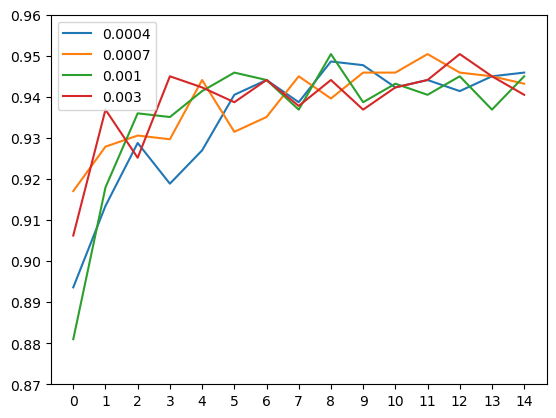

In [40]:
PlotHistory(scores_IN, lims=(0.87, 0.96))

### EfficientnetB7

In [32]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'efficientnetB7'
model_EN, history_EN, scores_EN = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/15
40/40 [==============================] - 70s 1s/step - loss: 0.6286 - accuracy: 0.8492 - val_loss: 0.1657 - val_accuracy: 0.9603
Epoch 2/15
40/40 [==============================] - 54s 1s/step - loss: 0.1553 - accuracy: 0.9520 - val_loss: 0.1223 - val_accuracy: 0.9639
Epoch 3/15
40/40 [==============================] - 54s 1s/step - loss: 0.1025 - accuracy: 0.9719 - val_loss: 0.1030 - val_accuracy: 0.9693
Epoch 4/15
40/40 [==============================] - 54s 1s/step - loss: 0.1043 - accuracy: 0.9750 - val_loss: 0.1018 - val_accuracy: 0.9702
Epoch 5/15
40/40 [==============================] - 53s 1s/step - loss: 0.1127 - accuracy: 0.9664 - val_loss: 0.0935 - val_accuracy: 0.9693
Epoch 6/15
40/40 [==============================] - 53s 1s/step - loss: 0.0884 - accuracy: 0.9805 - val_loss: 0.0905 - val_accuracy: 0.9720
Epoch 7/15
40/40 [==============================] - 5

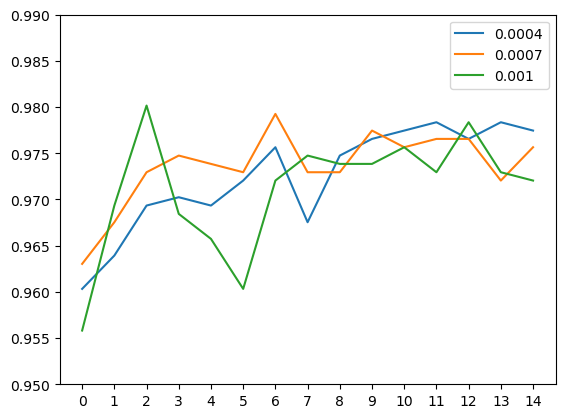

In [41]:
PlotHistory(scores_EN, lims=(0.95,0.99))

### ResNet50V2

In [34]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'ResNet50V2'
model_RN, history_RN, scores_RN = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/15
40/40 [==============================] - 23s 487ms/step - loss: 0.9237 - accuracy: 0.6872 - val_loss: 0.3828 - val_accuracy: 0.9053
Epoch 2/15
40/40 [==============================] - 17s 424ms/step - loss: 0.3245 - accuracy: 0.9008 - val_loss: 0.2227 - val_accuracy: 0.9405
Epoch 3/15
40/40 [==============================] - 17s 425ms/step - loss: 0.2352 - accuracy: 0.9297 - val_loss: 0.1846 - val_accuracy: 0.9423
Epoch 4/15
40/40 [==============================] - 17s 426ms/step - loss: 0.2016 - accuracy: 0.9368 - val_loss: 0.1616 - val_accuracy: 0.9468
Epoch 5/15
40/40 [==============================] - 17s 422ms/step - loss: 0.1676 - accuracy: 0.9516 - val_loss: 0.1398 - val_accuracy: 0.9513
Epoch 6/15
40/40 [==============================] - 17s 423ms/step - loss: 0.1571 - accuracy: 0.9523 - val_loss: 0.1353 - val_accuracy: 0.9567
Epoch 7/15
40/40 [=================

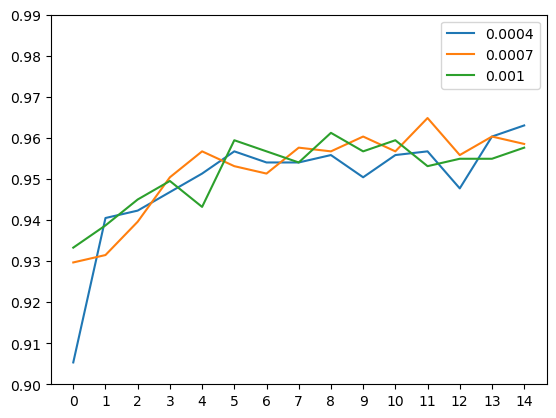

In [43]:
PlotHistory(scores_RN, lims=(0.9,0.99))

### VGG16

In [44]:
learningRates = [0.0005, 0.001, 0.005]
modelName = 'VGG16'
model_VGG, history_VGG, scores_VGG = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0005
Epoch 1/15
40/40 [==============================] - 29s 577ms/step - loss: 1.8580 - accuracy: 0.4500 - val_loss: 0.7676 - val_accuracy: 0.7511
Epoch 2/15
40/40 [==============================] - 19s 472ms/step - loss: 0.8255 - accuracy: 0.7164 - val_loss: 0.5437 - val_accuracy: 0.8269
Epoch 3/15
40/40 [==============================] - 19s 473ms/step - loss: 0.6384 - accuracy: 0.7961 - val_loss: 0.4590 - val_accuracy: 0.8476
Epoch 4/15
40/40 [==============================] - 19s 474ms/step - loss: 0.5382 - accuracy: 0.8266 - val_loss: 0.3993 - val_accuracy: 0.8665
Epoch 5/15
40/40 [==============================] - 19s 484ms/step - loss: 0.4314 - accuracy: 0.8560 - val_loss: 0.3600 - val_accuracy: 0.8819
Epoch 6/15
40/40 [==============================] - 19s 476ms/step - loss: 0.4367 - accuracy: 0.8576 - val_loss: 0.3458 - val_accuracy: 0.8855
Epoch 7/15
40/40 [=================

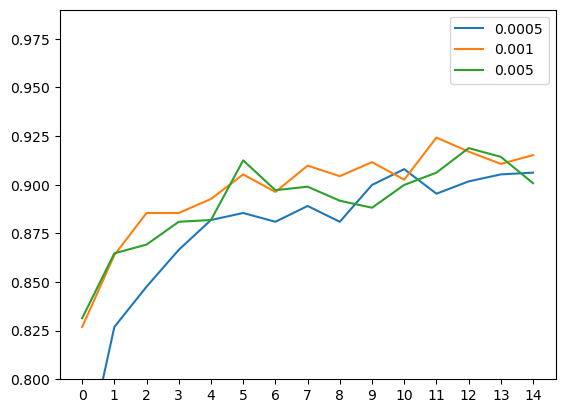

In [47]:
PlotHistory(scores_VGG, lims=(0.8,0.99))

In [182]:
#modelName = 'Xception'
modelName = 'VGG16'
droprate = 0.3

base_model = GetModel(modelName)

base_model.trainable = False

inputs = Input(shape=(pixels, pixels, 3))
base = base_model(inputs, training=False)
vectors = layers.GlobalAveragePooling2D()(base)

inner = layers.Dense(16, activation='relu')(vectors)
drop = layers.Dropout(droprate)(inner)

outputs = layers.Dense(6, activation='softmax')(drop)
model = Model(inputs, outputs)

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [183]:
model.summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_250 (InputLayer)       [(None, 500, 500, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 15, 15, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_39  (None, 512)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 16)                8208      
_________________________________________________________________
dropout_37 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 6)                 102       
Total params: 14,722,998
Trainable params: 8,310
Non-trainable params: 14,714,688
__________________________________________

In [184]:
len(model.trainable_variables)

4

In [185]:
train, val = DataGenerators (modelName, split=0.2)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.


In [186]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val)

70/70 [==============================] - 9s 122ms/step - loss: 4.3820 - accuracy: 0.1380


In [187]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.38
initial accuracy: 0.14


In [188]:
history = model.fit(train,
                    steps_per_epoch=50,
                    epochs=initial_epochs,
                    validation_data=val)

Epoch 1/10
50/50 [==============================] - 22s 429ms/step - loss: 1.8604 - accuracy: 0.3503 - val_loss: 1.2179 - val_accuracy: 0.5825
Epoch 2/10
50/50 [==============================] - 22s 431ms/step - loss: 1.2492 - accuracy: 0.5287 - val_loss: 0.9593 - val_accuracy: 0.6646
Epoch 3/10
50/50 [==============================] - 22s 438ms/step - loss: 1.0989 - accuracy: 0.5656 - val_loss: 0.8005 - val_accuracy: 0.7601
Epoch 4/10
50/50 [==============================] - 22s 435ms/step - loss: 1.0035 - accuracy: 0.6000 - val_loss: 0.6719 - val_accuracy: 0.7944
Epoch 5/10
50/50 [==============================] - 22s 438ms/step - loss: 0.8678 - accuracy: 0.6580 - val_loss: 0.5648 - val_accuracy: 0.8206
Epoch 6/10
50/50 [==============================] - 22s 432ms/step - loss: 0.7526 - accuracy: 0.7131 - val_loss: 0.5091 - val_accuracy: 0.8422
Epoch 7/10
50/50 [==============================] - 22s 445ms/step - loss: 0.7179 - accuracy: 0.7032 - val_loss: 0.4536 - val_accuracy: 0.8837

In [155]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


In [169]:
loss = history.history['loss']
val_loss = history.history['val_loss']

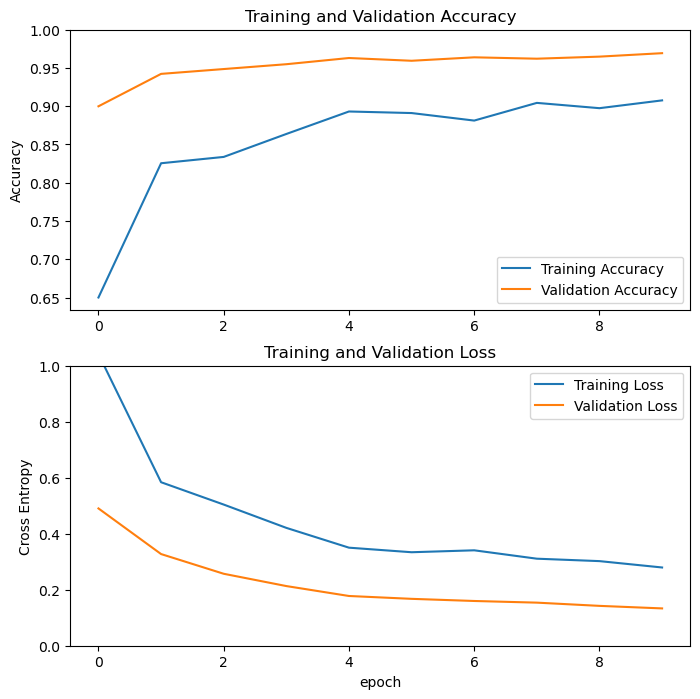

In [156]:


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [157]:
base_model.trainable = True


In [158]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  132


In [159]:
learning_rate = 0.001/10
optimizer = Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [160]:
model.summary()


Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_238 (InputLayer)       [(None, 500, 500, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_37  (None, 2048)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 16)                32784     
_________________________________________________________________
dropout_35 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 6)                 102       
Total params: 20,894,366
Trainable params: 9,511,230
Non-trainable params: 11,383,136
______________________________________

In [161]:
len(model.trainable_variables)

43

In [162]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train,
                         epochs=total_epochs,
                         steps_per_epoch=50,
                         initial_epoch=history.epoch[-1],
                         validation_data=val)


Epoch 10/20
50/50 [==============================] - 29s 510ms/step - loss: 0.2770 - accuracy: 0.9094 - val_loss: 0.0960 - val_accuracy: 0.9666
Epoch 11/20
50/50 [==============================] - 25s 499ms/step - loss: 0.2048 - accuracy: 0.9306 - val_loss: 0.0917 - val_accuracy: 0.9702
Epoch 12/20
50/50 [==============================] - 25s 500ms/step - loss: 0.1544 - accuracy: 0.9503 - val_loss: 0.0951 - val_accuracy: 0.9748
Epoch 13/20
50/50 [==============================] - 25s 504ms/step - loss: 0.1408 - accuracy: 0.9475 - val_loss: 0.1207 - val_accuracy: 0.9648
Epoch 14/20
50/50 [==============================] - 25s 501ms/step - loss: 0.1304 - accuracy: 0.9529 - val_loss: 0.1027 - val_accuracy: 0.9739
Epoch 15/20
50/50 [==============================] - 25s 502ms/step - loss: 0.1597 - accuracy: 0.9561 - val_loss: 0.1094 - val_accuracy: 0.9739
Epoch 16/20
50/50 [==============================] - 25s 506ms/step - loss: 0.1413 - accuracy: 0.9469 - val_loss: 0.1020 - val_accuracy:

In [170]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


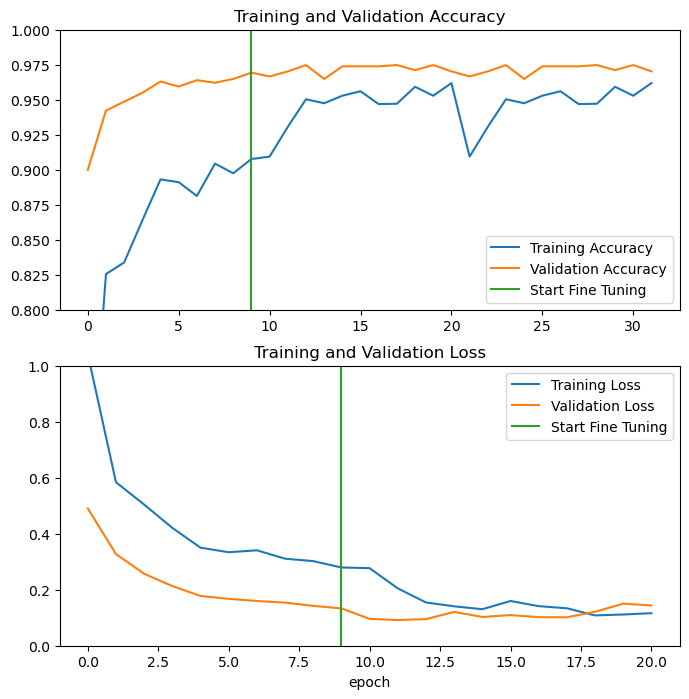

In [171]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
#########################################################

### Predict test labels

In [50]:
size = 128
droprate = 0.3
modelName = 'Xception'
newModel = MakeModel(modelName=modelName, learning_rate=0.001, size_inner=size, droprate=droprate)
newModel.load_weights('Xception_lr0.001_15_0.975.h5')

In [173]:
count =0
res = []
classes = train.class_indices
labels = dict((v, k) for k, v in classes.items())


preprocessInput = ProcInputs(modelName)
    
for file in os.listdir('./test'):
    imgPath = './test/' + file
    img = image.load_img(imgPath, target_size=(pixels, pixels))
    x = np.array(img)
    X = np.array([x])
    X = preprocessInput(X)
    preds = model.predict(X)

    label = labels[np.argmax(preds[0])]
    Id = file.split('.')[0]
    res.append([Id, label])
    if count%400==0:
        print(count, Id, label)
    count += 1

0 0000 cup
400 1027 spoon
800 1972 plate
1200 2915 plate
1600 3858 cup
2000 4812 fork
2400 5900 knife
2800 6914 knife
3200 7873 knife
3600 8944 plate


In [174]:
results = pd.DataFrame(res, columns=['Id', 'label'])
results

results.to_csv('submission_efficientnetB7_tunned.csv', index=False)

In [124]:
#####################

In [107]:
newModel1 = MakeModel(modelName='efficientnetB7', learning_rate=0.0004, size_inner=size, droprate=droprate)
newModel1.load_weights('Models/efficientnetB7_lr0.0004_13_0.980.h5')
newModel2 = MakeModel(modelName='efficientnetB7', learning_rate=0.001, size_inner=size, droprate=droprate)
newModel2.load_weights('Models/efficientnetB7_lr0.001_16_0.981.h5')
newModel3 = MakeModel(modelName='Xception', learning_rate=0.001, size_inner=size, droprate=droprate)
newModel3.load_weights('Models/Xception_lr0.001_10_0.976.h5')
newModel4 = MakeModel(modelName='VGG16', learning_rate=0.001, size_inner=size, droprate=droprate)
newModel4.load_weights('Models/VGG16_lr0.001_29_0.939.h5')

In [108]:
count =0
res = []
classes = trainGenerator.class_indices
labels = dict((v, k) for k, v in classes.items())


for file in os.listdir('./test'):
    imgPath = './test/' + file
    img = image.load_img(imgPath, target_size=(pixels, pixels))
    x = np.array(img)
    X = np.array([x])
    X = preprocess_input_xce(X)
    preds1 = newModel1.predict(X)
    preds2 = newModel2.predict(X)
    preds3 = newModel3.predict(X)
    preds4 = newModel4.predict(X)
    preds = preds1 * 0.35 + preds2 * 0.35 + preds3 * 0.2 + preds4 * 0.1 
    
    label = labels[np.argmax(preds[0])]
    Id = file.split('.')[0]
    res.append([Id, label])
    if count%400==0:
        print(count, Id, label)
    count += 1

0 0000 cup
400 1027 spoon
800 1972 plate
1200 2915 plate
1600 3858 cup
2000 4812 fork
2400 5900 knife
2800 6914 knife
3200 7873 knife
3600 8944 plate


In [109]:
results = pd.DataFrame(res, columns=['Id', 'label'])
results

results.to_csv('submission_full_combo.csv', index=False)